In [1]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

In [2]:
import cv2 as cv
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

from diffusers import DPMSolverMultistepScheduler, DiffusionPipeline
import torch

This notebook is a simple implementation of the inpainting process of a original size high quality mammograms.

# Creating healthy metadata

We first need a listo fo all the healthy mammograms.

In [12]:
# from utils import dataset_CDD_CESM, patient_CDD

# mode = 'substracted'
# dataset_CESM = dataset_CDD_CESM(mode=mode)
# print(dataset_CESM)

# # find normal cases
# normal_cases_meta = dataset_CESM.metadata[dataset_CESM.metadata['Tags']=='normal'].reset_index(drop=True)
# # save 
# normal_cases_meta.to_csv(repo_path / 'data/CDD-CESM/metadata' / 'normal_cases.csv', index=False)

# Generation idea
Check visually the normal cases, and their closeups

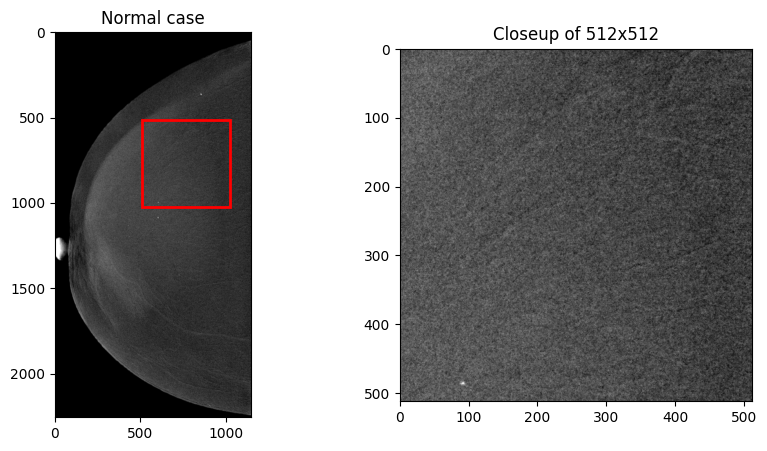

In [17]:
# data
im_dir = repo_path / 'data/CDD-CESM/images/substracted'
normal_cases_meta = pd.read_csv(repo_path / 'data/CDD-CESM/metadata' / 'normal_cases.csv')

# row_example
row = normal_cases_meta.iloc[2]

# load the image
im_path = im_dir / (row['Image_name'] + '.jpg')
im_path = im_path.with_name(im_path.name.replace(' ', '')) # rmeove space if necessary
im = cv.imread(str(im_path), cv.IMREAD_GRAYSCALE)

# closeup
x1, y1, x2, y2 = 512, 512, 1024, 1024

# show image
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(im, cmap='gray')
axs[0].set_title('Normal case')
# closup of 512x512
im_closup = im[y1:y2, x1:x2]
axs[1].imshow(im_closup, cmap='gray')
axs[1].set_title('Closeup of 512x512')
# show bbox of closeup in original image
axs[0].add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='r', lw=2))

plt.show()

im_closup = np.repeat(im_closup[:,:,None], 3, axis=2)

In [18]:
def compute_area_stas():

    training_mask_path = repo_path  /'data/CDD-CESM/metadata/bboxes/split_1/train_set.csv'
    train_set = pd.read_csv(training_mask_path)

    mask_areas = []
    for bbox in train_set['bbox']:
        bbox = eval(bbox)
        if bbox[2] < 512 and bbox[3] < 512: # excluding large cases
            # compute mask area
            mask_areas.append(bbox[2]*bbox[3])


    # get 25th and 75th percentiles
    q25, q75 = np.percentile(mask_areas, 25), np.percentile(mask_areas, 75)

    return q25, q75

def compute_ratios():
    
    training_mask_path = repo_path  /'data/CDD-CESM/metadata/bboxes/split_1/train_set.csv'
    train_set = pd.read_csv(training_mask_path)

    mask_ratios = []
    for bbox in train_set['bbox']:
        bbox = eval(bbox)
        if bbox[2] < 512 and bbox[3] < 512:
            # compute mask area
            mask_ratios.append(bbox[3]/bbox[2])
    
    # compute mean and std
    mean, std = np.mean(mask_ratios), np.std(mask_ratios)

    return mean, std

def create_lesion_bbox(im_xrange, im_yrange, area_range, ratio_range):
    while True:
        # sample x and y
        x1 = np.random.randint(im_xrange[0], im_xrange[1])
        y1 = np.random.randint(im_yrange[0], im_yrange[1])
        # sample area and ratio
        area = np.random.randint(area_range[0], area_range[1])
        ratio = np.random.uniform(ratio_range[0], ratio_range[1])

        # compute width and height
        width = int(np.sqrt(area*ratio))
        height = int(np.sqrt(area/ratio))

        # compute other corners
        x2 = x1 + width
        y2 = y1 + height

        # if all corners are inside the mask
        if x2 < im_xrange[1] and y2 < im_yrange[1]:
            # create mask of the bbox
            bbox_mask = np.zeros((im_xrange[1], im_yrange[1]), dtype=np.uint8)
            bbox_mask[y1:y2,x1:x2] = 255

            break
    
    return bbox_mask, (x1, y1, x2, y2)

25th percentile: 19832.0, 75th percentile: 98427.0
ratio mean: 1.0027800839513035, ratio std: 0.4185633550698671


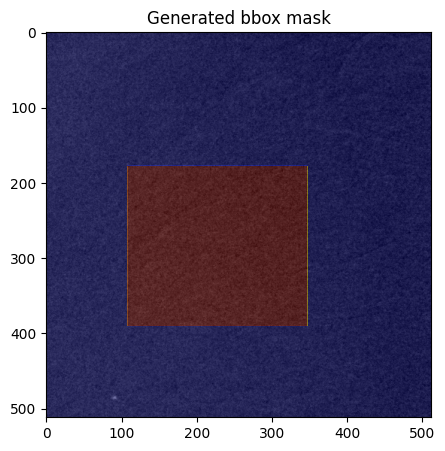

In [19]:
# compute area stats
q25, q75 = compute_area_stas()
print(f'25th percentile: {q25}, 75th percentile: {q75}')
mean, std = compute_ratios()
print(f'ratio mean: {mean}, ratio std: {std}')
# define ranges
area_range = (q25, q75)
ratio_range = (mean - std, mean + std)
im_xrange = (0, 512)
im_yrange = (0, 512)

# create bbox
bbox_mask, bbox = create_lesion_bbox(im_xrange, im_yrange, area_range, ratio_range)

plt.figure(figsize=(5,5))
plt.imshow(im_closup, cmap='gray')
plt.title('Generated bbox mask')
plt.imshow(bbox_mask, cmap='jet', alpha=0.4)
plt.show()

## Inpaiting process

In [25]:
# define model and load weights
model_dir=repo_path / 'generation/inpainting/results/CEM-small_mass_split-1'
# model_dir = 'runwayml/stable-diffusion-inpainting'
pipe = DiffusionPipeline.from_pretrained(
    model_dir,
    safety_checker=None,
    torch_dtype=torch.float16
).to("cuda")
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/ricardo/miniconda3/envs/diffusion_class/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [25]:
# Set diffusion pipeline
im_RGB = Image.fromarray(im_closup)
prompt = "a mammogram with a lesion"
negative_prompt = ""
num_samples = 1

 # HP
diffusion_steps = 50
guidance_scale = 1

with torch.autocast("cuda"), torch.inference_mode():
    synth = pipe(
        prompt=prompt,
        image=im_RGB,
        mask_image=bbox_mask, # mask coming from the sketchpad
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=diffusion_steps,
        guidance_scale=guidance_scale,
        height=512,
        width=512,
        generator=None,
    ).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

## Inpaint this patch back into the original image

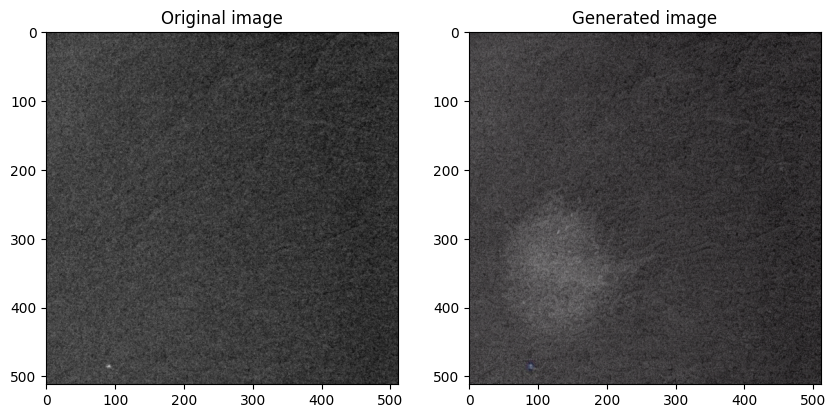

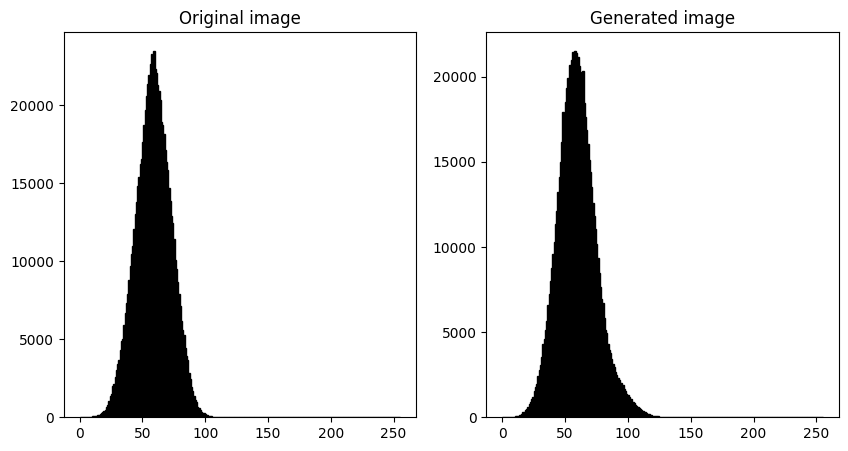

In [26]:
synth_array = np.asarray(synth)

# show orignal image histogram
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(im_closup, cmap='gray')
axs[0].set_title('Original image')
axs[1].imshow(synth_array, cmap='gray')
axs[1].set_title('Generated image')
plt.show()
# show histogram
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(im_closup.ravel(), bins=256, range=(0, 255), fc='k', ec='k')
axs[0].set_title('Original image')
axs[1].hist(synth_array.ravel(), bins=256, range=(0, 255), fc='k', ec='k')
axs[1].set_title('Generated image')
plt.show()

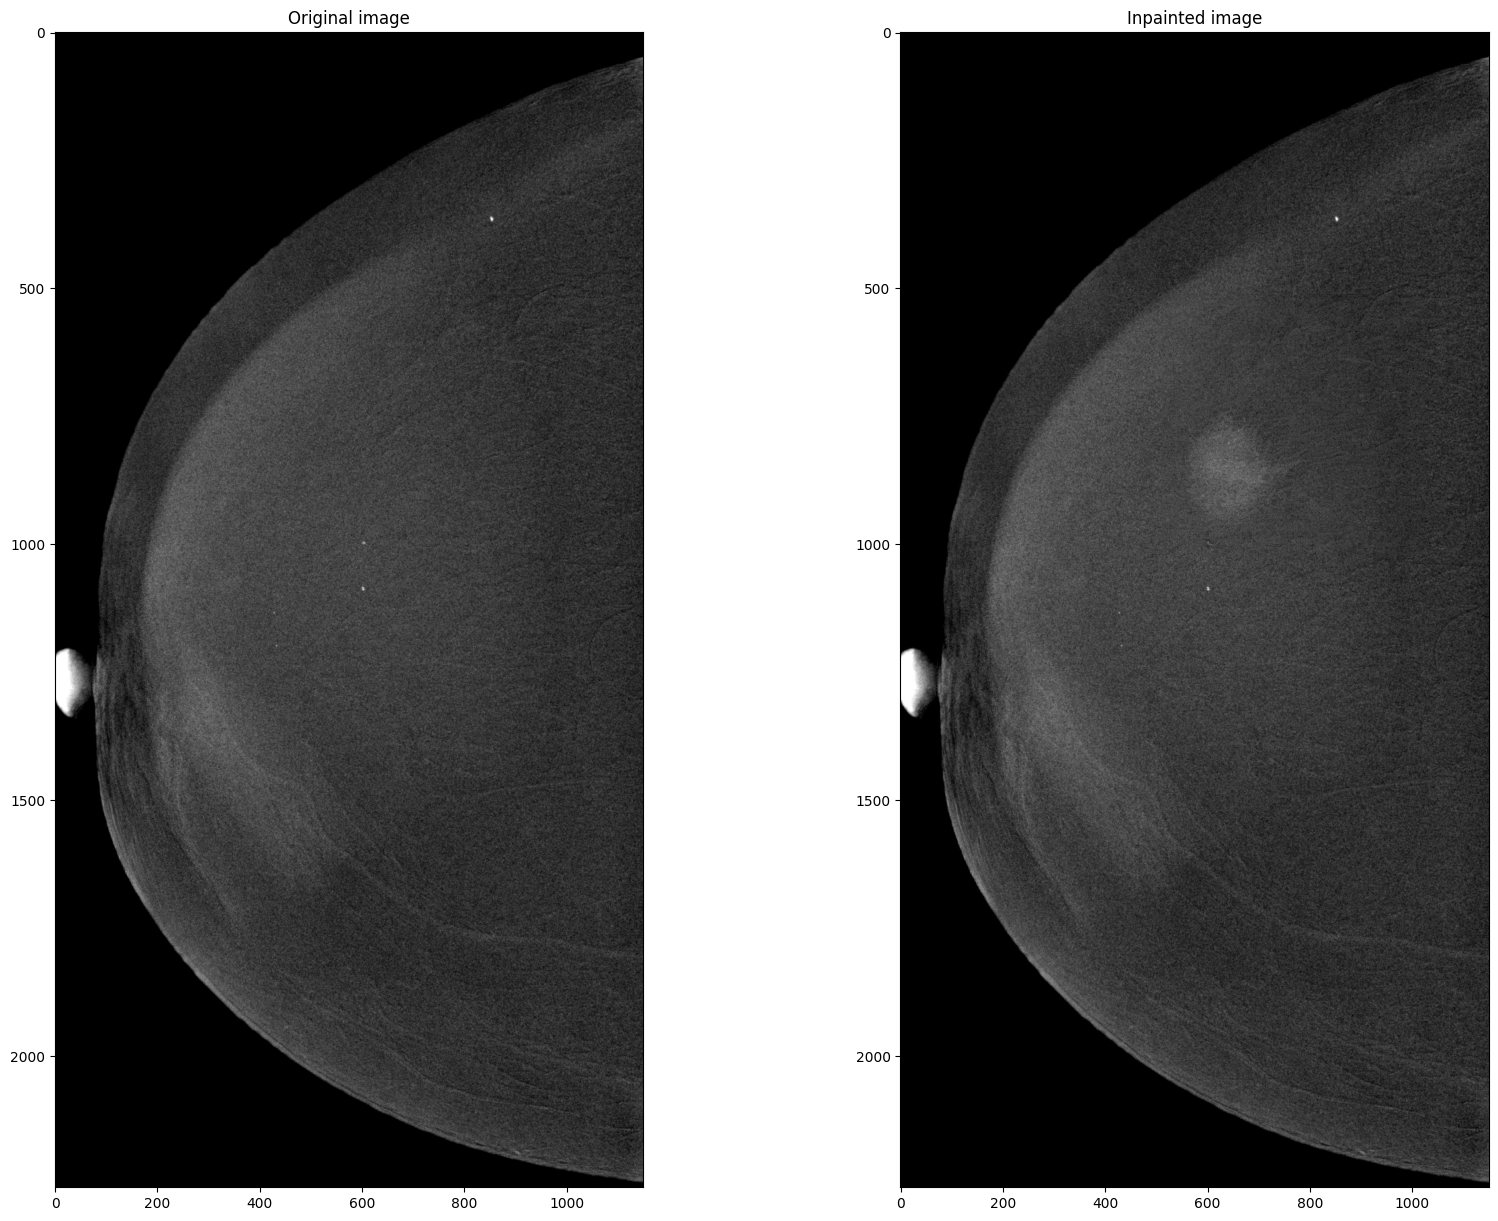

In [27]:
# reinstert in the orignal image
inpainted_im = im.copy()
inpainted_im[y1:y2, x1:x2] = synth_array[:,:,0]
# show orignal and inpainted image
fig, axs = plt.subplots(1, 2, figsize=(20, 15))
axs[0].imshow(im, cmap='gray')
axs[0].set_title('Original image')
axs[1].imshow(inpainted_im, cmap='gray')
axs[1].set_title('Inpainted image')
plt.show()

# Clean generation

Now we redo the pipeline but with completely randomize selection of regions

In [86]:
# create class for the generation of high resolution inpanted mammograms
class InpaintingGenerator:
    def __init__(self) -> None:
        self.load_data()
        self.current_row = None
        self.current_image = None
        self.current_mask = None

    def load_data(self):        
        # data
        self.im_dir = repo_path / 'data/CDD-CESM/images/substracted'
        self.metadata = pd.read_csv(repo_path / 'data/CDD-CESM/metadata' / 'normal_cases.csv')

    def set_generator(self, model_dir=None):
        model_dir=repo_path / 'generation/inpainting/results/CEM-small_mass_split-1' if model_dir is None else model_dir
        # model_dir = 'runwayml/stable-diffusion-inpainting'
        self.pipe = DiffusionPipeline.from_pretrained(
            model_dir,
            safety_checker=None,
            torch_dtype=torch.float16
        ).to("cuda")
        self.pipe.scheduler = DPMSolverMultistepScheduler.from_config(self.pipe.scheduler.config)
        self.pipe.enable_xformers_memory_efficient_attention()
        # HP
        self.diffusion_steps = 50
        self.guidance_scale = 1

    def read_image(self):
        im_path = self.im_dir / (self.current_row['Image_name'] + '.jpg')
        self.im_path = im_path.with_name(im_path.name.replace(' ', '')) # remove space if necessary
        im = cv.imread(str(self.im_path), cv.IMREAD_GRAYSCALE)
        self.current_image = im
    
    def get_breast_mask(self):
        _, _, mask = self.get_normal_BBox(self.current_image) # obtain breast binary mask
        kernel = np.ones((5,5),np.uint8)
        self.current_mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)

    def get_closeup(self):

        # sample from range of the image size
        width = 512
        height = 512
        while True:
            x1 = np.random.randint(0, self.current_image.shape[1])
            y1 = np.random.randint(0, self.current_image.shape[0])
            x2 = x1 + width
            y2 = y1 + height

            # check that the box limits are inside the image
            if x2 <= self.current_image.shape[1] and y2 <= self.current_image.shape[0]:
                break
        self.current_closeup_coords = (x1, y1, x2, y2)
        im_closup = self.current_image[y1:y2, x1:x2]
        self.current_mask_closup = self.current_mask[y1:y2, x1:x2]  
        self.current_im_closup = np.repeat(im_closup[:,:,None], 3, axis=2)

    def get_lesion_bbox(self):

        for _ in range(3):

            # compute area stats
            area_range, ratio_range = self.compute_area_ratio()
            # create bbox
            bbox_mask, bbox = self.create_lesion_bbox(xrange=(0, 512), yrange=(0, 512), area_range=area_range, ratio_range=ratio_range)

            # check bbox is fully inside the mask three times
            if np.all(self.current_mask_closup[bbox[1]:bbox[3],bbox[0]:bbox[2]]==255):
                self.current_bbox_mask = bbox_mask
                return True
        
        return False # did not find a bbox

    def get_normal_BBox(self, image):
        """This function returns the mask of the breast, as well as the boudnig box that encopasses it.

        Args:
            image (np.array): image as array

        Returns:
            omidb.bbox, np.array: returns omidb.box and mask image as np.arrays
        """

        mask = cv.threshold(image, 0, 255, cv.THRESH_BINARY)[1]
        nb_components, output, stats, _ = cv.connectedComponentsWithStats(mask, connectivity=4)
        sizes = stats[:, -1]
        max_label = 1
        max_size = sizes[1]
        for i in range(2, nb_components):
            if sizes[i] > max_size:
                max_label = i
                max_size = sizes[i]
        img2 = np.zeros(output.shape,dtype=np.uint8)
        img2[output == max_label] = 255
        contours, _ = cv.findContours(img2,cv.RETR_TREE,cv.CHAIN_APPROX_NONE)
        cnt = contours[0]
        aux_im = img2
        x,y,w,h = cv.boundingRect(cnt)
        cv.rectangle(aux_im,(x,y),(x+w,y+h),(255,0,0),5)
        out_bbox = (x, y, x+w, y+h)
        
        return out_bbox, img2, mask # returns bounding box and mask image.

    def compute_area_ratio(self):
        """Computes both area and ratio statistics needed for lesion mas selection

        Returns:
            tuple: area and ratio statistics
        """

        training_mask_path = repo_path  /'data/CDD-CESM/metadata/bboxes/split_1/train_set.csv'
        train_set = pd.read_csv(training_mask_path)

        mask_areas = []
        mask_ratios = []
        for bbox in train_set['bbox']:
            bbox = eval(bbox)
            if bbox[2] < 512 and bbox[3] < 512: # excluding large cases
                # compute mask area
                mask_areas.append(bbox[2]*bbox[3])
                mask_ratios.append(bbox[3]/bbox[2])


        # get area 25th and 75th percentiles and ratio mean and std
        q25, q75 = np.percentile(mask_areas, 25), np.percentile(mask_areas, 75)
        mean, std = np.mean(mask_ratios), np.std(mask_ratios)

        area_range = (q25, q75)
        ratio_range = (mean - std, mean + std)

        return area_range, ratio_range

    def create_lesion_bbox(self, xrange, yrange, area_range, ratio_range):
        """Creates a lesion bbox given the ranges of the image and the area and ratio statistics

        Args:
            xrange (tuple): x range of the image
            yrange (tuple): y range of the image
            area_range (tuple): area range of the lesion
            ratio_range (tuple): ratio range of the lesion

        Returns:
            np.array, tuple: returns bbox, (x1, y1, x2, y2)
        """
        while True:
            # sample x and y
            x1 = np.random.randint(xrange[0], xrange[1])
            y1 = np.random.randint(yrange[0], yrange[1])
            # sample area and ratio
            area = np.random.randint(area_range[0], area_range[1])
            ratio = np.random.uniform(ratio_range[0], ratio_range[1])

            # compute width and height
            width = int(np.sqrt(area*ratio))
            height = int(np.sqrt(area/ratio))

            # compute other corners
            x2 = x1 + width
            y2 = y1 + height

            # if all corners are inside the patch range
            if x2 < xrange[1] and y2 < yrange[1]:
                # create mask of the bbox
                bbox_mask = np.zeros((xrange[1], yrange[1]), dtype=np.uint8)
                bbox_mask[y1:y2,x1:x2] = 255

                break
        
        return bbox_mask, (x1, y1, x2, y2)
    
    def select_lesion_patch_and_bbox(self):
        """creates the patch and bbox for the current image, to use for inpainting
        Main attributes changed:
        - self.current_im_closup
        - self.current_closeup_coords
        - self.current_bbox_mask
        """
        # for the current image case
        self.read_image()
        self.get_breast_mask()
        found_bbox = False
        while not found_bbox:
            self.get_closeup()
            found_bbox = self.get_lesion_bbox()


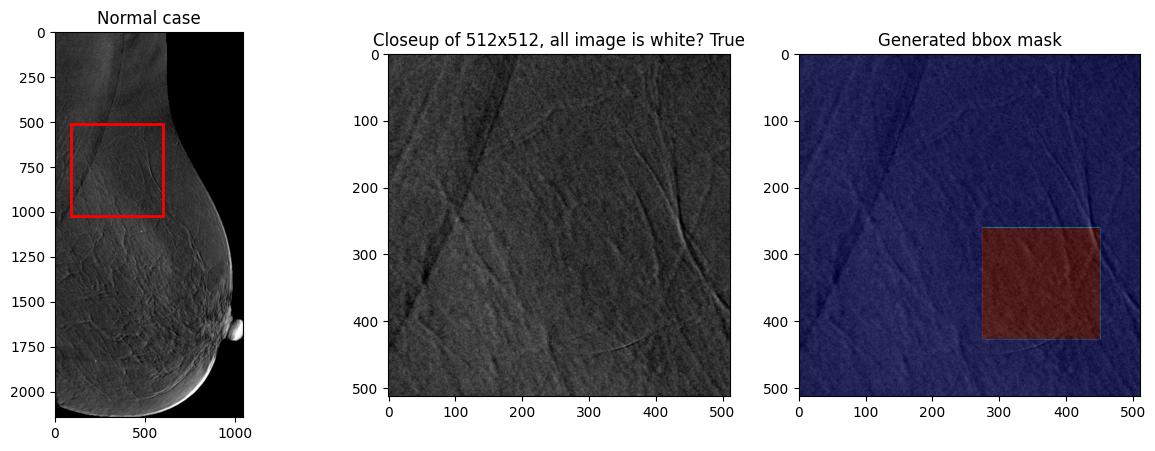

In [91]:
inpainter = InpaintingGenerator()
# row_example
inpainter.current_row = inpainter.metadata.iloc[5]

inpainter.select_lesion_patch_and_bbox()

# show image
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(inpainter.current_image, cmap='gray')
axs[0].set_title('Normal case')
axs[0].add_patch(plt.Rectangle((inpainter.current_closeup_coords[0], inpainter.current_closeup_coords[1]),
                                inpainter.current_closeup_coords[2]-inpainter.current_closeup_coords[0],
                                inpainter.current_closeup_coords[3]-inpainter.current_closeup_coords[1], fill=False, edgecolor='r', lw=2))
axs[1].imshow(inpainter.current_im_closup, cmap='gray')
axs[1].set_title(f'Closeup of 512x512, all image is white? {np.all(inpainter.current_mask_closup==255)}')
axs[2].imshow(inpainter.current_im_closup, cmap='gray')
axs[2].imshow(inpainter.current_bbox_mask, cmap='jet', alpha=0.4)
axs[2].set_title('Generated bbox mask')


plt.show()